## Data preparation and sanitization

In [173]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import seaborn as sb
import imblearn

# Read and sanitize the data
df = pd.read_excel("../data/UG_HH_NEW_continuous_no200.xls")
#df = pd.read_excel("./UG_HH_NEW_categorical_no200.xls")
df = df.dropna()

df_effort = df[['time_spent_prop', 'count_effort']]
df_effort = (df_effort - df_effort.min()) / (df_effort.max() - df_effort.min())

df['effort'] = df_effort['time_spent_prop'] * df_effort['count_effort']
df = df[['time_spent_risk', 'cells', 'selfish', 'effort',
         'Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]

#df = df[['selfish','Honesty_Humility','Extraversion', 'Agreeableness', 'min_offer']]


NORMALISE_DATA = True


x = df.values[:, :-1]
y = df.values[:, -1:]

if NORMALISE_DATA:
    x_min = x.min(axis=0)
    x_max = x.max(axis=0)
    x = (x - x_min) / (x_max - x_min)
    
NB_FEATURES = x.shape[1]

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size = 1/3, random_state = 0)

## Linear regression (continuous dataset)

**Accuracy / Loss - For model comparison**

In [174]:
MAX_GAIN = 200

def loss(min_offer, predicted):
    """
    Compute loss for the ultimatum game,
    as the difference between the possible gain and the actual one
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    rejected = min_offer > predicted
    res = predicted - min_offer
    if rejected.sum() != 0:
        res[rejected] = MAX_GAIN - min_offer[rejected]
    bad_predictions = (predicted < 0) | (predicted > MAX_GAIN)
    if bad_predictions.sum() != 0:
        res[bad_predictions] = MAX_GAIN - min_offer[bad_predictions]
    return res

def loss_sum(min_offer, predicted):
    return loss(min_offer, predicted).sum()

def avg_loss(min_offer, predicted):
    """
    Compute avg loss for the ultimatum game
    """
    return np.mean(loss(min_offer, predicted))

def mse(min_offer, predicted):
    """
    Compute mse using the loss as error
    """
    return np.mean(np.square(loss(min_offer, predicted)))

def rejection_ratio(min_offer, predicted):
    """
    Compute ratio of rejected proposals without consideration of values
    """
    accepted = (min_offer <= predicted)
    return 1 - np.mean(accepted)

def avg_win_loss(min_offer, predicted):
    """
    Compute avg_loss of accepted proposals
    """
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()
    accepted = (min_offer <= predicted)
    if accepted.sum() == 0:
        return 0
    return avg_loss(min_offer[accepted], predicted[accepted])


def gain(min_offer, predicted):
    min_offer = min_offer.ravel()
    predicted = predicted.ravel()    
    res = MAX_GAIN - predicted
    res[predicted < min_offer] = 0
    return res

def avg_loss_ratio(min_offer, predicted):
    """
    Compute the avg gain ratio in relation to the maximal gain
    """
    return 1 - np.mean(gain(min_offer, predicted) / gain(min_offer, min_offer))


#### Benchmark

In [175]:
benchmark_functions = [avg_loss, mse, rejection_ratio, avg_win_loss, avg_loss_ratio, loss_sum]

from sklearn.model_selection import KFold
import numpy as np

def process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs=None, predict_kwargs=None):
    fit_kwargs = {} if fit_kwargs is None else fit_kwargs
    predict_kwargs = {} if predict_kwargs is None else predict_kwargs
    model.fit(xTrain, yTrain, **fit_kwargs)
    yPredict = model.predict(xTest, **predict_kwargs)
    results = {func.__name__: func(yTest, yPredict) for func in benchmark_functions}
    return results
    
def process_benchmark_cv(model, X, y, cv=5, metrics=None, fit_kwargs=None, predict_kwargs=None, augment_kwargs=None):
    # We make sure original values aren't modified, even by mistake
    X = np.copy(X)
    y = np.copy(y)
    
    kf = KFold(n_splits=cv)
    results = []
    for train_index, test_index in kf.split(X):
        xTrain, yTrain = X[train_index], y[train_index]
        if augment_kwargs:
            xTrain, yTrain = DACombine().fit_predict(xTrain, yTrain, **augment_kwargs)
        xTest, yTest = X[test_index], y[test_index]
        benchmark_result = process_model(model, xTrain, yTrain, xTest, yTest, fit_kwargs, predict_kwargs)
        results.append(benchmark_result)
    return pd.DataFrame(results)

** Data augmentation **

In [185]:
class DACombine(object):
    def __init__(self, size=None, nb_features=NB_FEATURES, max_gain=MAX_GAIN):
        self.size = size
        self.nb_features = nb_features
        self.max_gain = max_gain
    
    def fit_predict(self, xTrain, yTrain, size=None, distance=10, upsample=True, include_xy=False, retarget=False, distribution=False, combine=False):
        """
        :param size: (int) size of the new generated dataset
        :param distance: (int) distance between parents or similar items
        :param upsample: (bool) if True, try balance the dataset
        :param include_xy: (bool) if True, include xTrain and yTrain to the data (on top of size items)
        :param retarget: (bool) if True, set all targets to the nearest higher multiple of distance without generating new samples
        :param distribution: (bool) if True, create new sample based on percentiles of features's std
        :param combine: (bool) if True: combine different methods (dist + retarget)
        """
        
        size = size or self.size or len(xTrain) * 4
        if combine:
            if distribution:
                xTrain, yTrain = self.dist_resample(xTrain, yTrain, size)
        else:
            if retarget:
                return self.retarget(xTrain, yTrain, distance)

            if distribution:
                return self.dist_resample(xTrain, yTrain, size)
    
        indices = np.arange(self.nb_features)
        np.random.shuffle(indices)
        targets = yTrain.ravel()
        if upsample:
            targets, counts = np.unique(yTrain, return_counts=True)
            #NOTE: minimize selection of target with only one sample
            probs = (1 - counts/counts.sum())**2
            probs[counts==1] = probs.min()
            probs /= probs.sum()
        else:
            targets = yTrain.ravel()
            probs = None
        xRes = []
        yRes = []
        if include_xy:
            xRes.extend(xTrain)
            yRes.extend(yTrain.ravel())
        for _ in range(size):
            target = np.random.choice(targets, p=probs)
            target_mask = (yTrain.ravel()<target+distance) & (yTrain.ravel()>=(target))
            xTrain_target = xTrain[target_mask]
            i = np.random.randint(xTrain_target.shape[0])
            j = np.random.randint(xTrain_target.shape[0])
            x = np.zeros_like(xTrain_target[0])
            np.random.shuffle(indices)
            split = np.random.randint(self.nb_features)
            mask_i = indices[:split]
            mask_j = indices[split:]
            x[mask_i] = xTrain_target[i, mask_i]
            x[mask_j] = xTrain_target[j, mask_j]
            xRes.append(x)
            yRes.append(target)
        xRes = np.array(xRes)
        yRes = np.array(yRes)
        if combine and retarget:
            return self.retarget(xRes, yRes, distance)
        return np.array(xRes), np.array(yRes)

    def retarget(self, xTrain, yTrain, distance=10):
        yNew = np.zeros(yTrain.shape[0])
        for y in np.arange(self.max_gain, 0, -distance):
            mask = (yTrain <= y) & (yTrain > y-distance)
            yNew[mask] = y + np.random.randint(0, distance, mask.shape)[mask]
        yNew = np.array(yNew)
        yNew[yNew > self.max_gain] = self.max_gain
        return xTrain, yNew
    
    def dist_resample(self, xTrain, yTrain, size=None, std_ratio=0.1):
        size = size or self.size or len(xTrain) * 4
        xTrain_mean = xTrain.mean()
        xTrain_std = xTrain.std()
        xNew = []
        yNew = []
        for _ in range(size):
            idx = np.random.randint(0, xTrain.shape[0])
            x = np.random.normal(xTrain[idx], xTrain_std*std_ratio)
            y = yTrain[idx]
            xNew.append(x)
            yNew.append(y)
        return np.array(xNew), np.array(yNew)
            

    def fit_resample(self, xTrain, yTrain, size=None, distance=5, include_xy=True):
        return self.fit_predict(xTrain, yTrain, size=size, distance=distance, include_xy=include_xy)

In [177]:
#keras
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import multiply
from keras.wrappers.scikit_learn import KerasRegressor
import keras.backend as K
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import tensorflow as tf
import sys


def sigmoid1024_tf(x):
    return (1024**x) / (1024**x + 1)

def sigmoid_tf(x):
    return K.sigmoid(x)

def gain_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.multiply(left_mul, right_mul)


def loss_tf(y_true, y_pred):
    math_pi = tf.constant(math.pi)
    one = tf.constant(1.0)
    ten = tf.constant(10.0)
    x0 = tf.math.subtract(y_true, y_pred)
    x = tf.math.truediv(x0, ten)
    left_mul = sigmoid_tf(x)
    right_mul = tf.math.cos(tf.math.divide(x, math_pi))
    return tf.math.subtract(one*2, tf.math.multiply(left_mul, right_mul))

def _keras_model(loss=None, metrics=None):
    """
    build a simple regression model
    :param loss: (str|callable, default: loss_tf)
    """
    if loss is None:
        loss = loss_tf
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(8, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(8, activation="relu"))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def _keras_linear_regression(loss=None, metrics=None):
    if loss is None:
        loss = "mse"
    if metrics is None:
        metrics = ["mse"]
    model = Sequential()
    model.add(Dense(1, input_dim=NB_FEATURES, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer='adam', metrics=metrics)
    return model

def keras_linear_regression(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_linear_regression(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)
    
def keras_model(loss=None, metrics=None, nb_epoch=100, batch_size=32, verbose=False):
    build_fn = lambda : _keras_model(loss, metrics)
    return KerasRegressor(build_fn=build_fn, epochs=nb_epoch, batch_size=batch_size, verbose=verbose)

**Linear regression**

(array([ 4,  5, 28, 13, 26, 38,  1,  3,  0,  1]),
 array([  0. ,  19.5,  39. ,  58.5,  78. ,  97.5, 117. , 136.5, 156. ,
        175.5, 195. ]))

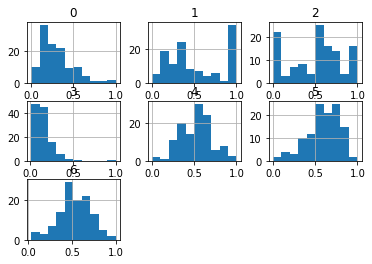

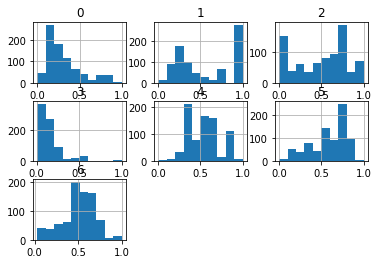

In [178]:
import imblearn
import imblearn.over_sampling
o_s = imblearn.over_sampling.RandomOverSampler()
xTrain_a, yTrain_a = o_s.fit_resample(xTrain, yTrain.ravel(), )
pd.DataFrame(xTrain).hist()
pd.DataFrame(xTrain_a).hist()
np.histogram(yTrain)

In [191]:
from sklearn.linear_model import LinearRegression, BayesianRidge, LogisticRegression, PassiveAggressiveRegressor, \
                                 ElasticNet, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble.bagging import BaggingRegressor, DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.svm import SVR, SVC
from sklearn.neural_network import MLPRegressor
benchmark_models = {
    'linear_regression': LinearRegression(), #LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'), #keras_linear_regression(nb_epoch=100, batch_size=60)
    'log_regression': LogisticRegression(penalty='l1', solver='liblinear', multi_class='auto'),
}
    
augment_params = {
    'base': {},
    'retarget': {'retarget': True, 'distance': 10},
#     'x2': {'size':len(xTrain)*2},
#     'x2-up': {'size':len(xTrain)*2, 'upsample': True},
#     'x2+xy': {'size':len(xTrain)*2, 'include_xy':True},
#     'x4': {'size': len(xTrain)*4},
#     'x4+xy-up': {'size': len(xTrain)*4, 'include_xy':True, 'upsample':True},
    'x16': {'size': len(xTrain)*16},
    'x16-up': {'size': len(xTrain)*16, 'upsample': True},
    'x16_dist': {'size': len(xTrain)*16, 'distribution': True},
    'x16_combine': {'size': len(xTrain)*16, 'retarget': True, 'distribution': True, 'upsample': True},
}

results = {}
for key, model in benchmark_models.items():
    for aug_key, aug_params in augment_params.items():
        results[key+"_" + aug_key] = process_benchmark_cv(model=model, X=x, y=y.ravel(), augment_kwargs=aug_params)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
linear_regression_base,66.760832,0.619677,25.299141,2390.192750,6236.575025,0.547302
linear_regression_retarget,60.494354,0.559989,26.520345,2165.906901,5369.486092,0.469048
linear_regression_x16,76.022773,0.691695,27.261765,2720.745870,7672.729765,0.625873
linear_regression_x16-up,73.015110,0.661813,26.564852,2614.044330,7342.903378,0.592063
linear_regression_x16_combine,60.690611,0.560757,26.740796,2172.990068,5394.117611,0.469048
linear_regression_x16_dist,67.022817,0.621765,25.952819,2399.656591,6248.532461,0.547302
log_regression_base,28.889683,0.238859,23.578000,1033.000000,1783.019841,0.095079
log_regression_retarget,35.382063,0.298694,26.749650,1267.600000,2378.544603,0.139048
log_regression_x16,79.748413,0.693918,37.701961,2854.000000,8635.765873,0.575873
log_regression_x16-up,85.020635,0.727323,42.134250,3041.000000,9363.555556,0.609683


** Actual best model:**
- LogisticRegression (penalty='l1')

** Data Augmentation improve following models:**
- BaggingRegression
- MLPRegressor

In [190]:
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, VotingClassifier
benchmark_models = {
    #'bag': BaggingRegressor(), 
    #'mlp': MLPRegressor(),
    'extra': ExtraTreesRegressor(),
}
    
augment_params = {
    'base': {},
    'retarget': {'retarget': True, 'distance': 10},
    'x16': {'size': len(xTrain)*16},
    'x16-up': {'size': len(xTrain)*16, 'upsample': True},
    'x16_dist': {'size': len(xTrain)*16, 'distribution': True},
    'x16_combine': {'size': len(xTrain)*16, 'retarget': True, 'distribution': True},
}

results = {}
for key, model in benchmark_models.items():
    for aug_key, aug_params in augment_params.items():
        results[key+"_" + aug_key] = process_benchmark_cv(model=model, X=x, y=y.ravel(), augment_kwargs=aug_params)

results_mean = {key: item.mean() for key, item in results.items()}
results_std = {key: item.std() for key, item in results.items()}
pd.DataFrame(results_mean).T

/home/franck/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


,avg_loss,avg_loss_ratio,avg_win_loss,loss_sum,mse,rejection_ratio
extra_base,63.261825,0.588282,25.038583,2267.100000,5791.847738,0.507619
extra_retarget,61.213413,0.564639,26.134481,2192.480000,5549.346300,0.474444
extra_x16,71.646986,0.660093,26.425445,2564.703636,6980.089286,0.592063
extra_x16-up,73.524963,0.676925,27.762957,2633.003782,7174.904159,0.608571
extra_x16_combine,59.958841,0.553705,28.125683,2149.360000,5294.585259,0.451587
extra_x16_dist,67.924206,0.625644,26.002177,2432.100000,6447.366389,0.547143


In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import L1L2

reg = L1L2(l1=0.01, l2=0.01)
model = Sequential()
model.add(Dense(1, activation='relu', input_dim=x.shape[1]),)# W_regularizer=reg,)
model.compile(optimizer='adam', loss='mse', metrics=[gain_tf])
xTrain_a, yTrain_a = DACombine().fit_predict(xTrain, yTrain, size=1024)
history = model.fit(xTrain_a, yTrain_a, nb_epoch=500, validation_split=0.25)


In [ ]:
yPred = model.predict(xTest)


In [ ]:
_, yy = DACombine().retarget(xTrain, yTrain.ravel(), 20)
#yy - yTrain.ravel()
yy
